In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/project/modified dataset/AQI/Karimnagar.csv',index_col='Month')
df.index.freq='MS'

In [ ]:
print('Shape of data',df.shape)

Shape of data (72, 1)


In [ ]:
df.head(),df.tail()

(         AQI
 Month       
 Jan-17  64.0
 Feb-17  64.0
 Mar-17  68.0
 Apr-17  69.0
 May-17  71.0,
          AQI
 Month       
 Aug-22  56.0
 Sep-22  56.0
 Oct-22  65.0
 Nov-22  58.0
 Dec-22  62.0)

In [ ]:
df = df.interpolate()

In [ ]:
df.isnull().sum()

AQI    0
dtype: int64

<Axes: title={'center': 'AQI'}, xlabel='Month'>

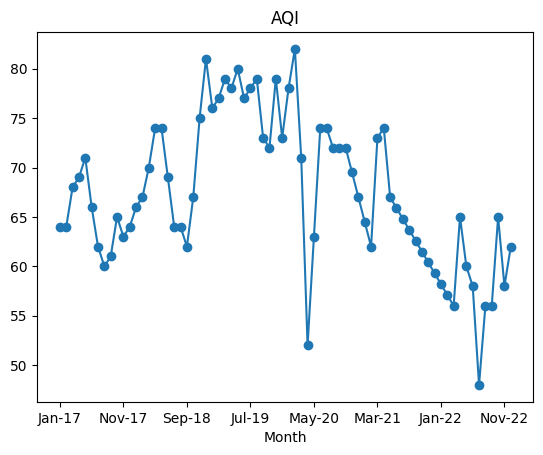

In [ ]:
df['AQI'][:100].plot(title="AQI", marker="o")

<Axes: xlabel='Month'>

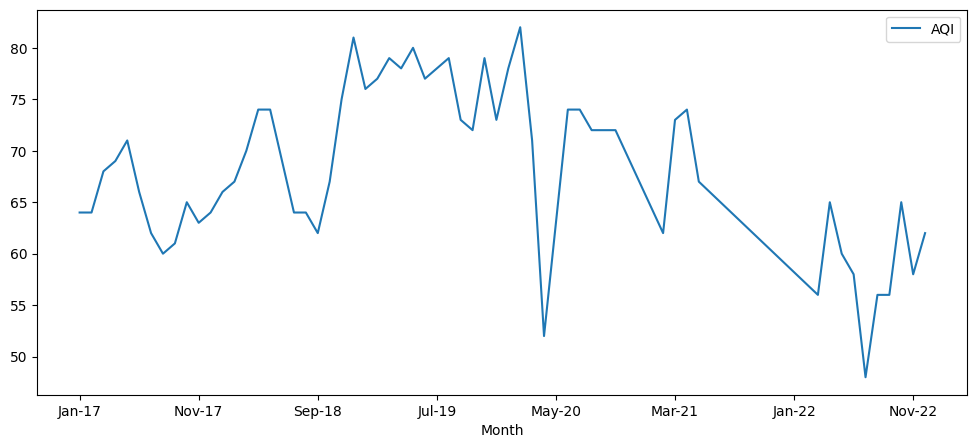

In [ ]:
df.plot(figsize=(12,5))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [ ]:
#Build the model
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import optimizers

In [ ]:
nb_epoch = 50
batch_size = 128
input_dim = df.shape[1] #num of columns,
encoding_dim = 18
hidden_dim1 = 10 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 6
learning_rate = 1e-7

In [ ]:
input_size = input_dim
hidden_sizes = [128,256,128]
input_layer = Input(shape=(input_size,))
encoder = Dense(hidden_sizes[0], activation = "relu")(input_layer)
encoder = Dense(hidden_sizes[1], activation = "relu")(encoder)
decoder = Dense(hidden_sizes[2], activation = 'relu')(encoder)
decoder = Dense(input_size)(decoder)
ae = Model(inputs=input_layer, outputs=decoder)
print(ae.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 128)               256       
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Compile the model
optimizer = optimizers.Adam(lr=0.0005)
ae.compile(optimizer = optimizer, loss='mean_squared_error')

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
!pwd

/content


In [ ]:
tensor_board = TensorBoard(log_dir='./logs/run1/',write_graph=True, write_images=False)
model_file = "model_ae.h5"
checkpoint = ModelCheckpoint(model_file, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history = ae.fit(df,df,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(df,df),
                          verbose=1,
                          callbacks=[checkpoint, tensor_board]).history

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.4541
Epoch 1: loss improved from inf to 0.45415, saving model to model_ae.h5
1/1 [==============================] - 1s 991ms/step - loss: 0.4541 - val_loss: 0.3979
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.3979
Epoch 2: loss improved from 0.45415 to 0.39795, saving model to model_ae.h5
1/1 [==============================] - 0s 108ms/step - loss: 0.3979 - val_loss: 0.3522
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.3522
Epoch 3: loss improved from 0.39795 to 0.35217, saving model to model_ae.h5
1/1 [==============================] - 0s 101ms/step - loss: 0.3522 - val_loss: 0.3124
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.3124
Epoch 4: loss improved from 0.35217 to 0.31241, saving model to model_ae.h5
1/1 [==============================] - 0s 108ms/step - loss: 0.3124 - val_loss: 0.2770
Epoch 5/50
1/1 [==============================] - ETA: 0s - 

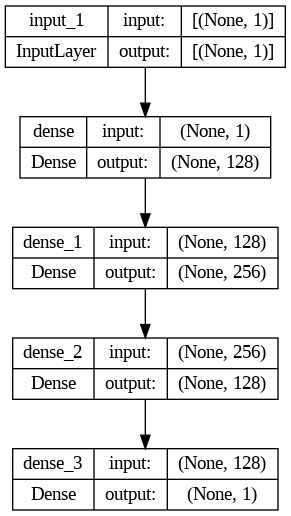

In [ ]:

from keras.utils.vis_utils import plot_model
plot_model(ae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
opt = keras.optimizers.legacy.SGD(lr=0.00005,decay=1e-6)
ae.compile(opt,loss="mse")

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#Reconstruction error
recon = ae.predict(df)
recon_error = np.mean(np.power(df-recon,2), axis=1)
#print(recon[1:10,:])
print(recon.shape)

3/3 [==============================] - 0s 7ms/step
(72, 1)


In [ ]:

main_df = pd.DataFrame(recon)

In [ ]:
main_df

,0
0,0.494492
1,0.494492
2,0.604051
3,0.631198
4,0.685318
...,...
67,0.272955
68,0.272955
69,0.521965
70,0.328638


In [ ]:
main_df = scaler.inverse_transform(main_df)

In [ ]:
main_df1=pd.DataFrame(main_df)

In [ ]:
main_df1.rename(columns = {0:'AQI',
                              }, inplace = True)

In [ ]:
main_df1

,AQI
0,64.812721
1,64.812721
2,68.537743
3,69.460739
4,71.300812
...,...
67,57.280472
68,57.280472
69,65.746826
70,59.173695


In [ ]:
main_df[0][0]

64.81272

In [ ]:
main_df1

,AQI
0,64.812721
1,64.812721
2,68.537743
3,69.460739
4,71.300812
...,...
67,57.280472
68,57.280472
69,65.746826
70,59.173695


In [ ]:
final_df = main_df1

In [ ]:
final_df

,AQI
0,64.812721
1,64.812721
2,68.537743
3,69.460739
4,71.300812
...,...
67,57.280472
68,57.280472
69,65.746826
70,59.173695


In [ ]:
#final_df.to_csv('/content/drive/MyDrive/project/modified dataset/AQI/Denoised_karimnagar_aqi.csv')

<Axes: >

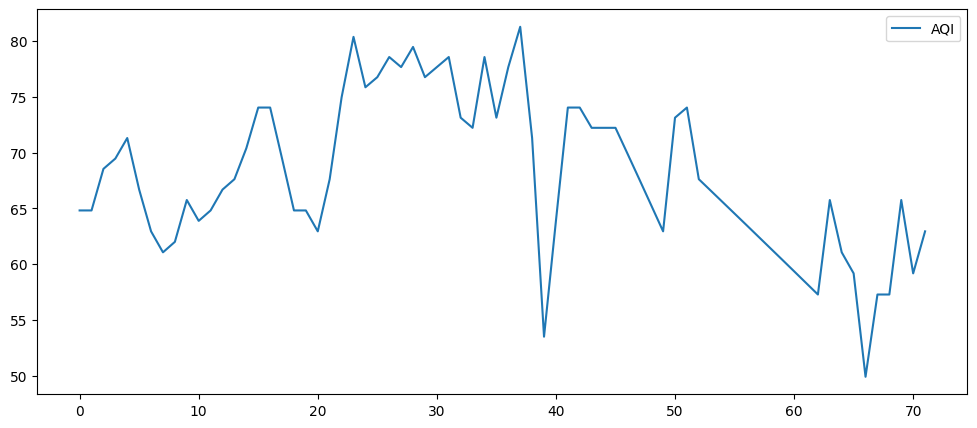

In [ ]:
final_df.plot(figsize=(12,5))

Check for stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def ad_test(dataset):
  dftest = adfuller(dataset, autolag='AIC')
  print("1. ADF:",dftest[0])
  print("2. P_value:",dftest[1])
  print("3. Num of lags:",dftest[2])
  print("4. Num of Observations used for ADF Regression and Critical Values Calculation:",dftest[3])
  print("5. Critical Values Calculation:")
  for key,val in dftest[4].items():
    print("\t",key,":",val)

In [ ]:
ad_test(final_df['AQI'])

1. ADF: -0.8282899690066924
2. P_value: 0.8106705520459703
3. Num of lags: 5
4. Num of Observations used for ADF Regression and Critical Values Calculation: 66
5. Critical Values Calculation:
	 1% : -3.5335601309235605
	 5% : -2.9064436883991434
	 10% : -2.590723948576676


Figure out order for arima model

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.2 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
#Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
stepwise_fit = auto_arima(final_df['AQI'],trace = True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=420.823, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=426.590, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=428.471, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=428.308, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=424.592, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=421.228, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=419.714, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=422.183, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=425.038, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=421.356, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=421.779, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=419.791, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=417.890, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=420.364, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=423.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -204.945
Date:                Wed, 26 Apr 2023   AIC                            417.890
Time:                        09:26:07   BIC                            426.940
Sample:                             0   HQIC                           421.489
                                 - 72                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5533      0.212      2.606      0.009       0.137       0.969
ar.L2         -0.2726      0.143     -1.905      0.057      -0.553       0.008
ma.L1         -0.7301      0.193     -3.783      0.000      -1.108      -0.352
sigma2        18.6863      2.865      6.522      0.000      13.071      24.302
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                20.35
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.72
Prob(H) (two-sided):                  0.10   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Split Data into Training and Testing

In [ ]:
print(final_df.shape)
train = final_df.iloc[:-12]
test = final_df.iloc[-12:]
print(train.shape,test.shape)

(72, 1)
(60, 1) (12, 1)


Create ARIMA model

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.tsa.ARIMA(train['AQI'], order=(2,1,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                   60
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -165.987
Date:                Wed, 26 Apr 2023   AIC                            339.974
Time:                        09:26:13   BIC                            348.284
Sample:                             0   HQIC                           343.218
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6265      0.248      2.527      0.011       0.141       1.112
ar.L2         -0.4139      0.151     -2.746      0.006      -0.709      -0.118
ma.L1         -0.6614      0.266     -2.486      0.013      -1.183      -0.140
sigma2        16.0865      2.644      6.083      0.000      10.904      21.269
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                22.69
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.81
Prob(H) (two-sided):                  0.39   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Make Predictions on Test set

<Axes: >

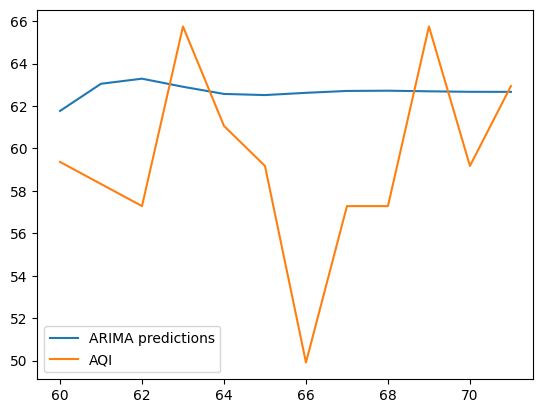

In [ ]:
start = len(train)
end = len(train)+len(test)-1
pred=model.predict(start=start,end=end,type='levels').rename('ARIMA predictions')
pred.plot(legend=True)
test['AQI'].plot(legend=True)

In [ ]:
test['AQI'].mean()

59.439697

Performance Analsis

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred,test['AQI']))
print("rmse value = ",rmse)

rmse value =  5.227329839235058


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['AQI'],pred)
print("mean absolute error = ",mae)

mean absolute error =  4.268796960800759


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(test["AQI"],pred)
r2

-0.6342661322234686

In [ ]:
#Mean Absolute Percentage Error
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

In [ ]:
MAPE = mape(test["AQI"],pred)
print("Mean Absolute Percentage Error = ",round((MAPE*100),2),"%")

Mean Absolute Percentage Error =  7.54 %


Future Prediction

In [ ]:
model2 = sm.tsa.arima.ARIMA(final_df['AQI'],order=(2,1,1))
model2 = model2.fit()
final_df.tail

<bound method NDFrame.tail of           AQI
0   64.597809
1   64.597809
2   68.224342
3   69.125549
4   70.921333
..        ...
67  57.275719
68  57.275719
69  65.502800
70  59.115643
71  62.772285

[72 rows x 1 columns]>

In [ ]:
index_future_dates=pd.date_range(start='Jan-2023',end='Feb-2024',freq = 'M')
pred = model2.predict(start=len(final_df),end=len(final_df)+12,type='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
#print(index_future_dates)
print(pred)

2023-01-31    62.362803
2023-02-28    61.138828
2023-03-31    60.574511
2023-04-30    60.596804
2023-05-31    60.763105
2023-06-30    60.848876
2023-07-31    60.850873
2023-08-31    60.828571
2023-09-30    60.815708
2023-10-31    60.814688
2023-11-30    60.817635
2023-12-31    60.819541
2024-01-31    60.819790
Freq: M, Name: ARIMA Predictions, dtype: float64
